# Download Dataset

In [ ]:
%mkdir -p /csc413/project/
%cd /csc413/project
!pip install tensorflow-addons

import os
import cv2
import imageio
import json
import shutil
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from six.moves.urllib.request import urlretrieve


########################################################################
# Global Variables
########################################################################
EPOCH = 30
DATA_SIZE = 200 #100, 150, 200
BATCH_SIZE = 5
IMAGE_SIZE = [256, 256]
OUTPUT_CHANNELS = 3
ARTIST = 4
all_artist = {"Monet": 0, 
          "Vangogh": 1, 
          "Ukiyoe": 2
          }
losses = {
    'artist_gen_loss': [],
    'photo_gen_loss': [],
    'artist_disc_loss': [],
    'photo_disc_loss': []
}


/csc413/project
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 31.2 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
if os.path.exists("/CycleGAN_test_photo.zip"):
  %mv /CycleGAN_test_photo.zip /csc413/project/CycleGAN_test_photo.zip
elif os.path.exists("/content/CycleGAN_test_photo.zip"):
  %mv /content/CycleGAN_test_photo.zip /csc413/project/CycleGAN_test_photo.zip

In [ ]:
zip_path = "/csc413/project/CycleGAN_test_photo.zip"
datadir = "/csc413/project/"
with zipfile.ZipFile(zip_path,"r") as zip_ref:
      zip_ref.extractall(datadir)

# Setup

In [ ]:
device = "/gpu:0"

# Create a OneDeviceStrategy for the given device
strategy = tf.distribute.OneDeviceStrategy(device)
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)
print(type(strategy))

Number of replicas: 1
2.12.0
<class 'tensorflow.python.distribute.one_device_strategy.OneDeviceStrategy'>


# Load Data

In [ ]:
def download(zip_to_download_name, filename):
  origin = "https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/"
  origin += zip_to_download_name

  datadir = os.path.join("data")
  if not os.path.exists(datadir):
      os.makedirs(datadir)

  zip_path = os.path.join(datadir, filename)
  zip_path = zip_path + ".zip"

  urlretrieve(origin, zip_path)

  with zipfile.ZipFile(zip_path,"r") as zip_ref:
      zip_ref.extractall(datadir)


# Define a function to load and preprocess each image
def load_and_preprocess_image(filepath):
    # Load the image file
    image = tf.io.read_file(filepath)
    # Decode the JPEG-encoded image to a uint8 tensor
    image = tf.image.decode_jpeg(image, channels=3)
    # Preprocess the image (e.g., resize, normalize, augment)
    image = image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image


def load_dataset(img_dir):
    print(img_dir)
    filepaths = tf.data.Dataset.list_files(os.path.join(img_dir, "*.jpg"))
    filepaths = filepaths.take(DATA_SIZE)
    dataset = filepaths.map(load_and_preprocess_image)
    return dataset


In [ ]:
download("vangogh2photo.zip", "vangogh")
download("ukiyoe2photo.zip", "ukiyoe")
download("monet2photo.zip", "monet")

In [ ]:
monet_ds = load_dataset("data/monet2photo/trainA").batch(BATCH_SIZE)
vangogh_ds = load_dataset("data/vangogh2photo/trainA").batch(BATCH_SIZE)
ukiyoe_ds = load_dataset("data/ukiyoe2photo/trainA").batch(BATCH_SIZE)
photo_ds = load_dataset("data/monet2photo/trainB").batch(BATCH_SIZE)
test_photo_ds = load_dataset("CycleGAN_test_photo")

data/monet2photo/trainA
data/vangogh2photo/trainA
data/ukiyoe2photo/trainA
data/monet2photo/trainB
CycleGAN_test_photo


In [ ]:
example_monet = next(iter(monet_ds))
example_vangogh = next(iter(vangogh_ds))
example_ukiyoe = next(iter(ukiyoe_ds))
example_photo = next(iter(photo_ds))
example_test_photo = next(iter(test_photo_ds))

In [ ]:
print(example_monet.shape)
print(example_photo.shape)
print(example_test_photo.shape)

(5, 256, 256, 3)
(5, 256, 256, 3)
(256, 256, 3)


In [ ]:
for i, img in enumerate(test_photo_ds):
  print(img.shape)


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


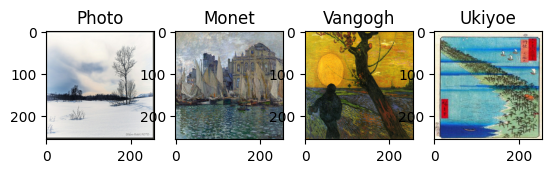

In [ ]:
plt.subplot(141)
plt.title('Photo')
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(142)
plt.title('Monet')
plt.imshow(example_monet[0] * 0.5 + 0.5)

plt.subplot(143)
plt.title('Vangogh')
plt.imshow(example_vangogh[0] * 0.5 + 0.5)

plt.subplot(144)
plt.title('Ukiyoe')
plt.imshow(example_ukiyoe[0] * 0.5 + 0.5)

# Generator

In [ ]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization
                   (gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())
    return result

In [ ]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

In [ ]:
def Generator():
    rgb_inputs = layers.Input(shape=(256, 256, 3), name='rgb_image')
    tensor_inputs = layers.Input(shape=(1,), name='tensor_input')

    # bs = batch size
    down_stack1 = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
    ]
    down_stack2 = [
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = rgb_inputs
    label = tensor_inputs

    # Embed label to vector
    lbls = layers.Embedding(4, 8, embeddings_initializer='glorot_uniform', 
                            name='Generator-Label-Embedding-Layer')(label)  

    # Scale up to image dimensions
    n_nodes = 16
    lbls = layers.Dense(n_nodes, activation='relu', 
                        kernel_initializer='glorot_uniform', 
                        name='Generator-Label-Dense-Layer')(lbls)
    lbls = layers.Reshape((4, 4, 1), name='Generator-Label-Reshape-Layer')(lbls)  # New shape

    # Downsampling through the model
    skips = []
    for down in down_stack1:
        x = down(x)
        skips.append(x)
    x = layers.Concatenate(name='Generator-Combine-Layer')([x, lbls])
    
    for down in down_stack2:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=[rgb_inputs, tensor_inputs], outputs=x)

# Discriminator

In [ ]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    rgb_inputs = layers.Input(shape=(256, 256, 3), name='rgb_image')
    tensor_inputs = layers.Input(shape=(1,), name='tensor_input')


    x = rgb_inputs

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    label = tensor_inputs

    lbls = layers.Embedding(4, 32, embeddings_initializer='glorot_uniform',
                            name='Generator-Label-Embedding-Layer')(label)  # Embed label to vector

    # Scale up to image dimensions
    n_nodes = 32*32
    lbls = layers.Dense(n_nodes, activation='relu', 
                        kernel_initializer='glorot_uniform', 
                        name='Generator-Label-Dense-Layer')(lbls)
    lbls = layers.Reshape((32, 32, 1), name='Generator-Label-Reshape-Layer')(lbls)  # New shape
    down3 = layers.Concatenate(name='Generator-Combine-Layer')([down3, lbls])

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) 
    # (bs, 30, 30, 1)
    
    return tf.keras.Model(inputs=[rgb_inputs, tensor_inputs], outputs=last)

In [ ]:
with strategy.scope():
    # transforms photos to Monet-esque paintings
    monet_generator = Generator() 

    # transforms Monet paintings to be more like photos
    photo_generator = Generator() 

    # differentiates real Monet paintings and generated Monet paintings
    monet_discriminator = Discriminator() 

     # differentiates real photos and generated photos
    photo_discriminator = Discriminator()

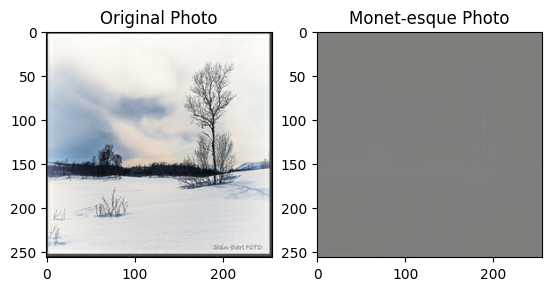

In [ ]:
artist_m = tf.fill((BATCH_SIZE, 1), 0)
to_monet = monet_generator([example_photo, artist_m])

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_photo[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

# CycleGAN Model

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, data):
      """
      Training step of the model
      :param self: the model 
      :param data: the data to train the model
      :param artist: 
          1: Monet
          2: Vangogh
          3: Ukiyoe
      :return: the respective losses 
      """
      real_artist, real_photo = data
      artist = ARTIST
      # Stack the row_value tensor batchsize times 
      # to create a tensor of size [batchsize, 4]
      photo_tensor = tf.fill((BATCH_SIZE, 1), 3)
      # Stack the row_value tensor batchsize times 
      # to create a tensor of size [batchsize, 4]
      artist_tensor = tf.fill((BATCH_SIZE, 1), artist)


      with tf.GradientTape(persistent=True) as tape:

          # photo to monet back to photo
          fake_artist = self.m_gen((real_photo, artist_tensor), training=True)
          cycled_photo = self.p_gen((fake_artist, photo_tensor), training=True)

          # monet to photo back to monet
          fake_photo = self.p_gen((real_artist, photo_tensor), training=True)
          cycled_artist = self.m_gen((fake_photo, artist_tensor), training=True)

          # generating itself
          same_artist = self.m_gen((real_artist, artist_tensor), training=True)
          same_photo = self.p_gen((real_photo, photo_tensor), training=True)

          # discriminator used to check, inputing real images
          disc_real_artist = self.m_disc((real_artist, artist_tensor), 
                                         training=True)
          disc_real_photo = self.p_disc((real_photo, photo_tensor), 
                                        training=True)

          # discriminator used to check, inputing fake images
          disc_fake_artist = self.m_disc((fake_artist, artist_tensor), 
                                         training=True)
          disc_fake_photo = self.p_disc((fake_photo, photo_tensor), 
                                        training=True)

          # evaluates generator loss
          artist_gen_loss = self.gen_loss_fn(disc_fake_artist)
          photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

          # evaluates total cycle consistency loss
          total_cycle_loss = self.cycle_loss_fn(real_artist, cycled_artist,
                                                self.lambda_cycle) + self.cycle_loss_fn(real_photo,
                                                                                        cycled_photo,
                                                                                        self.lambda_cycle)

          # evaluates total generator loss
          total_artist_gen_loss = artist_gen_loss + total_cycle_loss + self.identity_loss_fn(real_artist,
                                                                                          same_artist,
                                                                                          self.lambda_cycle)
          total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo,
                                                                                          same_photo,
                                                                                          self.lambda_cycle)

          # evaluates discriminator loss
          artist_disc_loss = self.disc_loss_fn(disc_real_artist, disc_fake_artist)
          photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

      # Calculate the gradients for generator and discriminator
      artist_generator_gradients = tape.gradient(total_artist_gen_loss,
                                                self.m_gen.trainable_variables)
      photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                self.p_gen.trainable_variables)

      artist_discriminator_gradients = tape.gradient(artist_disc_loss,
                                                    self.m_disc.trainable_variables)
      photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                    self.p_disc.trainable_variables)

      # Apply the gradients to the optimizer
      self.m_gen_optimizer.apply_gradients(zip(artist_generator_gradients,
                                              self.m_gen.trainable_variables))

      self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                              self.p_gen.trainable_variables))

      self.m_disc_optimizer.apply_gradients(zip(artist_discriminator_gradients,
                                                self.m_disc.trainable_variables))

      self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                self.p_disc.trainable_variables))

      return {
          "artist_gen_loss": total_artist_gen_loss,
          "photo_gen_loss": total_photo_gen_loss,
          "artist_disc_loss": artist_disc_loss,
          "photo_disc_loss": photo_disc_loss
      }

# Loss Function

In [ ]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [ ]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [ ]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Train

In [ ]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False
)
    photo_generator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False
)
    monet_discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False
)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False
)

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
losses = {
    'artist_gen_loss': [],
    'photo_gen_loss': [],
    'artist_disc_loss': [],
    'photo_disc_loss': []
}


In [ ]:
ARTIST = all_artist["Vangogh"]
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((vangogh_ds, photo_ds)),
    epochs=EPOCH
)
for i in range(EPOCH):
  losses['artist_gen_loss'].append(float(np.mean(history.history['artist_gen_loss'][i])))
  losses['photo_gen_loss'].append(float(np.mean(history.history['photo_gen_loss'][i])))
  losses['artist_disc_loss'].append(float(np.mean(history.history['artist_disc_loss'][i])))
  losses['photo_disc_loss'].append(float(np.mean(history.history['photo_disc_loss'][i])))

ARTIST = all_artist["Monet"]
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=EPOCH
)
for i in range(EPOCH):
  losses['artist_gen_loss'].append(float(np.mean(history.history['artist_gen_loss'][i])))
  losses['photo_gen_loss'].append(float(np.mean(history.history['photo_gen_loss'][i])))
  losses['artist_disc_loss'].append(float(np.mean(history.history['artist_disc_loss'][i])))
  losses['photo_disc_loss'].append(float(np.mean(history.history['photo_disc_loss'][i])))

ARTIST = all_artist["Ukiyoe"]
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((ukiyoe_ds, photo_ds)),
    epochs=EPOCH
)
for i in range(EPOCH):
  losses['artist_gen_loss'].append(float(np.mean(history.history['artist_gen_loss'][i])))
  losses['photo_gen_loss'].append(float(np.mean(history.history['photo_gen_loss'][i])))
  losses['artist_disc_loss'].append(float(np.mean(history.history['artist_disc_loss'][i])))
  losses['photo_disc_loss'].append(float(np.mean(history.history['photo_disc_loss'][i])))

Epoch 1/30
40/40 [==============================] - 91s 915ms/step - artist_gen_loss: 7.4923 - photo_gen_loss: 7.4203 - artist_disc_loss: 0.6529 - photo_disc_loss: 0.6650
Epoch 2/30
40/40 [==============================] - 37s 914ms/step - artist_gen_loss: 4.9100 - photo_gen_loss: 4.5491 - artist_disc_loss: 0.5496 - photo_disc_loss: 0.6571
Epoch 3/30
40/40 [==============================] - 36s 907ms/step - artist_gen_loss: 4.4537 - photo_gen_loss: 4.1955 - artist_disc_loss: 0.6627 - photo_disc_loss: 0.6480
Epoch 4/30
40/40 [==============================] - 37s 913ms/step - artist_gen_loss: 4.3232 - photo_gen_loss: 4.1318 - artist_disc_loss: 0.6287 - photo_disc_loss: 0.6561
Epoch 5/30
40/40 [==============================] - 36s 910ms/step - artist_gen_loss: 3.9596 - photo_gen_loss: 3.8445 - artist_disc_loss: 0.6288 - photo_disc_loss: 0.6350
Epoch 6/30
40/40 [==============================] - 36s 911ms/step - artist_gen_loss: 3.7855 - photo_gen_loss: 3.6002 - artist_disc_loss: 0.6097 

# Visualize

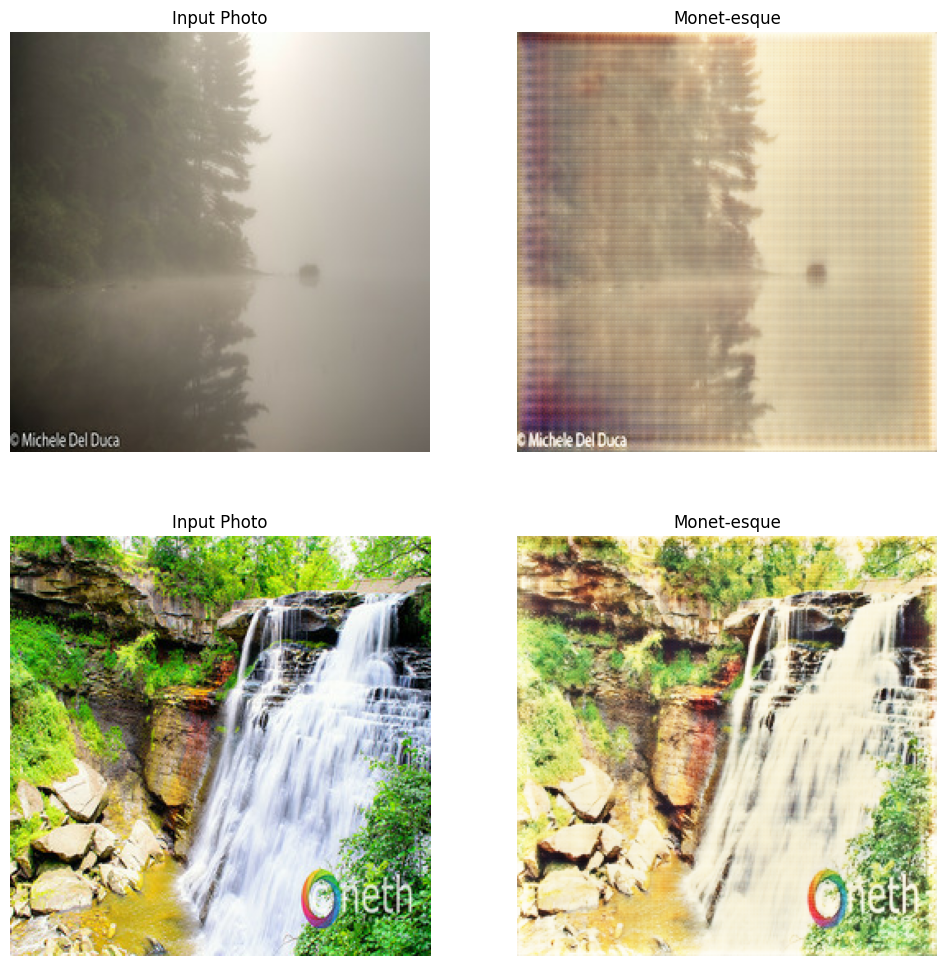

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(2)):
    prediction = monet_generator([img, tf.fill((BATCH_SIZE, 1), 0)], training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    cv2.imwrite("prediction.jpg", prediction)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# Record Loss

In [ ]:
print(f"Data size is {DATA_SIZE}")
print("loss_artist_gen is:")
print(losses['artist_gen_loss'])
print("loss_photo_gen is:")
print(losses['photo_gen_loss'])
print("loss_artist_disc is:")
print(losses['artist_disc_loss'])
print("loss_photo_disc is:")
print(losses['photo_disc_loss'])


Data size is 200
loss_artist_gen is:
[5.022603511810303, 5.2099480628967285, 4.292403697967529, 4.082921981811523, 3.9979734420776367, 3.8416054248809814, 3.670125961303711, 3.494581699371338, 4.598850727081299, 3.235264778137207, 3.557788610458374, 3.408787727355957, 3.3050360679626465, 3.226821184158325, 2.9581449031829834, 2.8810975551605225, 3.335261344909668, 3.3255808353424072, 3.2545721530914307, 3.1486542224884033, 2.585322141647339, 2.5528883934020996, 2.5971710681915283, 2.582482099533081, 2.7345049381256104, 2.777127504348755, 2.68664813041687, 2.5531094074249268, 2.911660671234131, 2.6365437507629395, 2.4447786808013916, 2.0597939491271973, 2.2708933353424072, 2.2868831157684326, 1.9316996335983276, 2.449850082397461, 2.2913658618927, 2.3897769451141357, 2.3766818046569824, 2.1554157733917236, 2.4341917037963867, 2.3555908203125, 2.223900556564331, 1.9329079389572144, 2.2539496421813965, 2.3087661266326904, 2.0153636932373047, 2.491697072982788, 2.2335994243621826, 2.149610

In [ ]:
with open('result.json', 'w') as f:
     f.write(json.dumps(losses))

# Save Model

In [ ]:
output_dir = "out_image"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i, img in enumerate(test_photo_ds):
    img = tf.expand_dims(img, axis=0)
    img = tf.tile(img, [5, 1, 1, 1])
    
    monet = monet_generator([img, tf.fill((BATCH_SIZE, 1), all_artist["Monet"])], training=False)[0].numpy()
    monet = (monet * 127.5 + 127.5).astype(np.uint8)

    vangogh = monet_generator([img, tf.fill((BATCH_SIZE, 1), all_artist["Vangogh"])], training=False)[0].numpy()
    vangogh = (vangogh * 127.5 + 127.5).astype(np.uint8)

    ukiyoe = monet_generator([img, tf.fill((BATCH_SIZE, 1), all_artist["Ukiyoe"])], training=False)[0].numpy()
    ukiyoe = (ukiyoe * 127.5 + 127.5).astype(np.uint8)

    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    imageio.imwrite(os.path.join(output_dir, f"photo_{i}.jpg"), img)
    imageio.imwrite(os.path.join(output_dir, f"monet_{i}.jpg"), monet)
    imageio.imwrite(os.path.join(output_dir, f"vangogh_{i}.jpg"), vangogh)
    imageio.imwrite(os.path.join(output_dir, f"ukiyoe_{i}.jpg"), ukiyoe)

In [ ]:
# monet to vangogh
output_dir = "out_image"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

photo_monet_out_dir = "p_to_m"
if not os.path.exists(photo_monet_out_dir):
    os.makedirs(photo_monet_out_dir)
    
photo_to_monet = [file for file in os.listdir("out_image") if file[0] == "m"]
for filename in photo_to_monet:
  shutil.copy(f"{output_dir}/{filename}", f"{photo_monet_out_dir}/{filename}")

photo_to_monet_ds = load_dataset(photo_monet_out_dir)

for i, img in enumerate(photo_to_monet_ds):
    img = tf.expand_dims(img, axis=0)
    img = tf.tile(img, [5, 1, 1, 1])

    vangogh = monet_generator([img, tf.fill((BATCH_SIZE, 1), all_artist["Vangogh"])], training=False)[0].numpy()
    vangogh = (vangogh * 127.5 + 127.5).astype(np.uint8)
    imageio.imwrite(os.path.join(output_dir, f"monet_vangogh_{i}.jpg"), vangogh)


p_to_m


In [ ]:
# vangogh to monet
output_dir = "out_image"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

photo_vangogh_out_dir = "p_to_v"
if not os.path.exists(photo_vangogh_out_dir):
    os.makedirs(photo_vangogh_out_dir)

photo_to_vangogh = [file for file in os.listdir("out_image") if file[0] == "v"]
for filename in photo_to_vangogh:
  shutil.copy(f"{output_dir}/{filename}", f"{photo_vangogh_out_dir}/{filename}")

photo_to_vangogh_ds = load_dataset(photo_vangogh_out_dir)

for i, img in enumerate(photo_to_vangogh_ds):
    img = tf.expand_dims(img, axis=0)
    img = tf.tile(img, [5, 1, 1, 1])

    monet = monet_generator([img, tf.fill((BATCH_SIZE, 1), all_artist["Monet"])], training=False)[0].numpy()
    monet = (monet * 127.5 + 127.5).astype(np.uint8)
    imageio.imwrite(os.path.join(output_dir, f"vangogh_monet_{i}.jpg"), monet)

p_to_v


In [ ]:
!zip -r out_image.zip out_image

  adding: out_image/ (stored 0%)
  adding: out_image/vangogh_monet_0.jpg (deflated 12%)
  adding: out_image/photo_2.jpg (deflated 3%)
  adding: out_image/vangogh_5.jpg (deflated 1%)
  adding: out_image/monet_3.jpg (deflated 1%)
  adding: out_image/ukiyoe_3.jpg (deflated 1%)
  adding: out_image/monet_vangogh_4.jpg (deflated 2%)
  adding: out_image/photo_3.jpg (deflated 1%)
  adding: out_image/photo_4.jpg (deflated 1%)
  adding: out_image/vangogh_monet_5.jpg (deflated 2%)
  adding: out_image/monet_vangogh_1.jpg (deflated 1%)
  adding: out_image/ukiyoe_4.jpg (deflated 2%)
  adding: out_image/ukiyoe_0.jpg (deflated 1%)
  adding: out_image/vangogh_0.jpg (deflated 1%)
  adding: out_image/monet_2.jpg (deflated 6%)
  adding: out_image/monet_vangogh_0.jpg (deflated 2%)
  adding: out_image/vangogh_2.jpg (deflated 6%)
  adding: out_image/monet_vangogh_3.jpg (deflated 12%)
  adding: out_image/monet_vangogh_5.jpg (deflated 1%)
  adding: out_image/vangogh_4.jpg (deflated 2%)
  adding: out_image/ukiy